Initializing reader and loading graph...
Assigning speed and travel times for edges...
Simplifying graph...
Plotting graph...


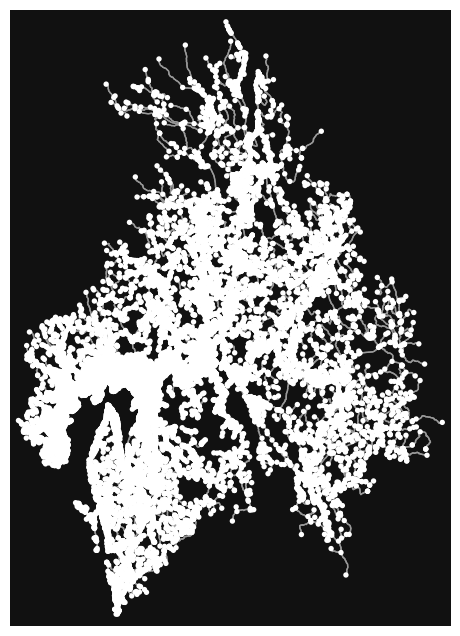

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [1]:
from pyrosm import OSM
import osmnx as ox
import networkx as nx

print("Initializing reader and loading graph...")
# Initialize the reader
osm = OSM("data/osm/oslo_akershus_highways.osm.pbf")
# Read nodes and edges of the 'driving' network
nodes, edges = osm.get_network(nodes=True, network_type="driving")
# Create NetworkX graph
G = osm.to_graph(nodes, edges, graph_type="networkx")

print("Assigning speed and travel times for edges...")
# Assign speeds to edges missing data based on dict values.
# For edges with highway type not in dict, impute speeds.
hwy_speeds = {'motorway': 80,
              'trunk': 70,
              'primary': 50,
              'secondary': 40,
              'tertiary': 40,
              'unclassified': 40,
              'residential': 30}
# Add speed and calculate travel time for edges
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

print("Simplifying graph...")
# remove geometry attribute from edges as simplify will create it
for n1, n2, d in G.edges(data=True):
    d.pop('geometry', None)
# remove unnecessary nodes
G = ox.simplify_graph(G, False, True)

print("Plotting graph...")
ox.plot_graph(G)

In [2]:
import pandas as pd

def load_coordinates():
    # get grid coordinates
    grids = pd.read_csv("data/grid_centroids.csv")
    grids = grids[["lat", "long"]]
    grids["type"] = "grid"
    # get base station coordinates
    base_stations = pd.read_csv("data/base_stations.csv")
    base_stations = base_stations[["latitude", "longitude"]]
    base_stations.columns = ("lat", "long")
    base_stations["type"] = "base_station"
    # get base station coordinates
    hospitals = pd.read_csv("data/hospitals.csv")
    hospitals = hospitals[["lat", "long"]]
    hospitals["type"] = "hospital"
    # combine coordinates
    combined = pd.concat([grids, base_stations, hospitals], ignore_index=True)
    ids = combined.index.values
    xs = combined["long"].values
    ys = combined["lat"].values
    return combined, ids, xs, ys, grids

In [3]:
from coordinate_converter import node_to_id

print("Getting coordinates from csv...")
combined, ids, xs, ys, grids = load_coordinates()

print("Finding the coordinates' closest nodes...")
nearest_nodes = ox.nearest_nodes(G, xs, ys, False)

print("Creating ssb ids from coordinates...")
ssb_ids = [node_to_id(id, type, xs, ys) for id, _, _, type in combined.itertuples()]


Getting coordinates from csv...
Finding the coordinates' closest nodes...
Creating ssb ids from coordinates...


3355
['22880006644000', '22860006648000', '22820006652000', '22760006651000', '22690006651000', '22640006648000', '22590006649000', '22540006648000', '22480006645000', '22420006641000']


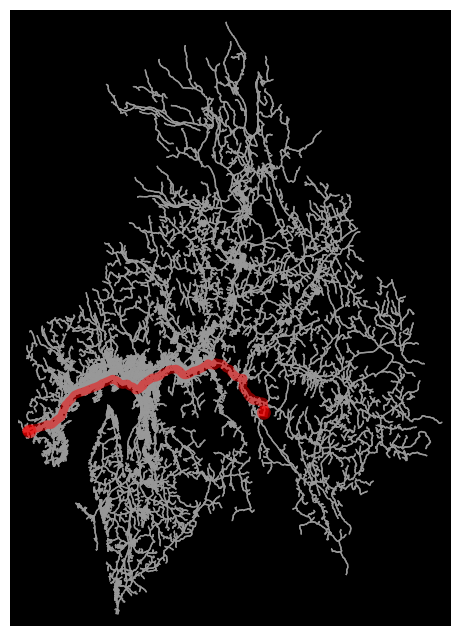

In [4]:
from coordinate_converter import get_route_info

lat_a, lon_a = 59.857862376445844,11.258730422230418
lat_b, lon_b = 59.81994583616233,10.352368185671335

a = ox.nearest_nodes(G, lon_a, lat_a)
b = ox.nearest_nodes(G, lon_b, lat_b)

# find shortest path (by travel time)
route = nx.shortest_path(G, a, b, weight="travel_time")

# get travel time and route grids
travel_time, route_grids = get_route_info(G, grids, ssb_ids, route, 5)

print(travel_time)
print(route_grids)

# plot route
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')